In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import keras
import warnings
warnings.filterwarnings('ignore')
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import glob
from utils import simple_unet_model, load_image, imageLoader
# setup on_epoch_end() to stop training when accuracy reaches 90%
import segmentation_models_3D as sm
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint 


Segmentation Models: using `tf.keras` framework.


In [2]:
train_img_dir = "D:\deeplearning\deploy_brain_tumor_detector\BraTS_2020\BraTS2020_TrainingData\preprocess_train\images/"
train_mask_dir = "D:\deeplearning\deploy_brain_tumor_detector\BraTS_2020\BraTS2020_TrainingData\preprocess_train\masks/"
train_img_list = os.listdir(train_img_dir)
train_mask_list  = os.listdir(train_mask_dir)
# valid_img_dir = "D:\deeplearning\deploy_brain_tumor_detector\BraTS_2020\BraTS2020_ValidationData\preprocess_valid/"

In [3]:
# checking to verify if the train images corresonds to the masks
for i in range(len(train_img_list)-1):
    if train_mask_list[i].split('_')[1] == train_img_list[i].split('_')[1]:
        pass
    else:
        print(False)

In [4]:
# define batch size for trial

batch_size = 1
train_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
img, msk = train_datagen.__next__()

In [5]:
img.shape, msk.shape

((2, 128, 128, 128, 3), (2, 128, 128, 128, 4))

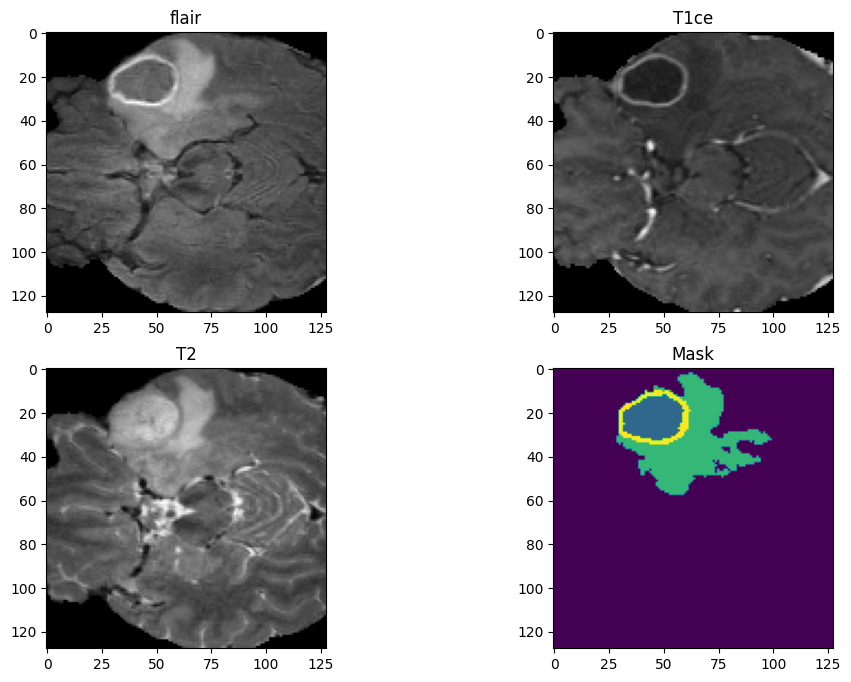

In [13]:
img_num = random.randint(0, img.shape[0]-1)
tst_img = img[img_num]
tst_msk = msk[img_num]
tst_msk = np.argmax(tst_msk, axis=3)
n_slice1 = random.randint(0, tst_msk.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(tst_img[:,:, n_slice1, 0], cmap='grey')
plt.title('flair')
plt.subplot(222)
plt.imshow(tst_img[:,:, n_slice1, 1], cmap='grey')
plt.title('T1ce')
plt.subplot(223)
plt.imshow(tst_img[:,:, n_slice1, 2], cmap='grey')
plt.title('T2')
plt.subplot(224)
plt.imshow(tst_msk[:,:, n_slice1])
plt.title('Mask')
plt.show()

In [14]:

model = simple_unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input[0][0]       │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [15]:
diceLoss = sm.losses.DiceLoss()
focaLoss = tf.keras.losses.CategoricalFocalCrossentropy()






# Define a custom loss function combining Dice Loss and Focal Loss
def combined_loss(y_true, y_pred):
    dice = diceLoss(y_true, y_pred)
    focal = focaLoss(y_true, y_pred)
    return dice + focal

In [16]:
metrics_ = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
optimizer_ = tf.keras.optimizers.Adam(learning_rate=0.001)

In [17]:
steps_per_epoch = len(train_img_list)//batch_size

In [18]:
model.compile(optimizer=optimizer_, loss=combined_loss, metrics=metrics_)
# model.summary()

In [19]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint(
    filepath="3D-UNet-2020-weights-improvement-{epoch:02d}-{loss:.3f}.hdf5",  
    monitor='loss',            
    save_best_only=True,       
    verbose=1
)

In [20]:
history = model.fit(train_datagen, 
                    steps_per_epoch = steps_per_epoch,
                    epochs = 100,
                    verbose = 1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
161/172 ━━━━━━━━━━━━━━━━━━━━ 10:54 60s/step - accuracy: 0.8960 - iou_score: 0.1894 - loss: 0.8390

Note: you may need to restart the kernel to use updated packages.
